В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [43]:
!pip install opendatasets --upgrade --quiet

In [44]:
import opendatasets as od
import pandas as pd
import numpy as np

od.download('https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2/data')
train_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/train.csv')

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-2" (use force=True to force download)


In [45]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split

train_df = train_df.drop(columns=['id', 'CustomerId', 'Surname'])

train_df = pd.get_dummies(train_df, columns=['Geography', 'Gender'], drop_first=True)

input_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
              'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']
target_col = 'Exited'

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    train_df[input_cols], train_df[target_col], test_size=0.2, random_state=42
)


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [47]:
numeric_cols = train_df.select_dtypes(include=['number']).columns.tolist()

categorical_cols = train_df.select_dtypes(include=['object']).columns.tolist()


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

numeric_cols = [col for col in train_inputs.columns if train_inputs[col].dtype in ['int64', 'float64']]
categorical_cols = [col for col in train_inputs.columns if train_inputs[col].dtype == 'object']

imputer = SimpleImputer(strategy='median')
train_inputs[numeric_cols] = imputer.fit_transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])

scaler = StandardScaler()
train_inputs[numeric_cols] = scaler.fit_transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

if categorical_cols:
    train_inputs = pd.get_dummies(train_inputs, columns=categorical_cols, drop_first=True)
    val_inputs = pd.get_dummies(val_inputs, columns=categorical_cols, drop_first=True)

from IPython.display import display
display(train_inputs.head())
display(val_inputs.head())


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9839,-0.005452,0.034419,1.431840,-0.711819,-1.110115,0.515968,-0.979053,0.043440,False,True,False
9680,0.796518,0.034419,0.354008,-0.711819,2.630269,0.515968,-0.979053,0.899369,False,False,False
7093,-0.904212,-0.087489,1.431840,1.669468,0.760077,-1.938103,1.021395,1.289040,True,False,False
11293,0.049856,1.741125,-1.442379,1.116976,-1.110115,0.515968,-0.979053,1.683999,True,False,True
820,-0.420265,0.156326,0.713285,0.625216,0.760077,0.515968,1.021395,-0.725591,True,False,True


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
11499,-0.046934,-0.209397,-1.083102,0.654761,0.760077,-1.938103,1.021395,-0.031301,True,False,True
6475,-0.793596,3.082109,-0.005269,0.841116,-1.110115,0.515968,-0.979053,1.292172,False,False,True
13167,0.381706,-0.575119,0.354008,1.401712,0.760077,0.515968,-0.979053,0.658282,True,False,True
862,-1.097791,1.009679,-1.442379,1.413988,-1.110115,-1.938103,-0.979053,1.194443,False,False,True
5970,0.326397,-0.331304,-0.364547,2.016339,-1.110115,0.515968,1.021395,-0.468583,False,True,False


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [49]:
import os
import pandas as pd

save_dir = "/mnt/data/"
os.makedirs(save_dir, exist_ok=True)

train_targets_df = pd.DataFrame(train_targets, columns=[target_col])
val_targets_df = pd.DataFrame(val_targets, columns=[target_col])

train_inputs.to_parquet(os.path.join(save_dir, "train_inputs.parquet"))
train_targets_df.to_parquet(os.path.join(save_dir, "train_targets.parquet"))
val_inputs.to_parquet(os.path.join(save_dir, "val_inputs.parquet"))
val_targets_df.to_parquet(os.path.join(save_dir, "val_targets.parquet"))

print(os.listdir(save_dir))


['train_targets.parquet', 'val_inputs.parquet', 'train_inputs.parquet', 'log_reg.joblib', 'val_targets.parquet']


6. З підготовлених вхідних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [50]:
from sklearn.linear_model import LogisticRegression

X_train = train_inputs.copy()
X_val = val_inputs.copy()

model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, train_targets)

print("Коефіцієнти моделі:", model.coef_)
print("Значення зміщення (intercept):", model.intercept_)


Коефіцієнти моделі: [[-0.11441694  1.28168009 -0.03513663 -0.29195568 -0.7063938  -0.07152429
  -0.65304487  0.0527866   1.54680118 -0.08844556 -0.84026581]]
Значення зміщення (intercept): [-1.88703175]


7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Train AUROC: 0.8817, Train F1 Score: 0.6318
Validation AUROC: 0.8827, Validation F1 Score: 0.6480


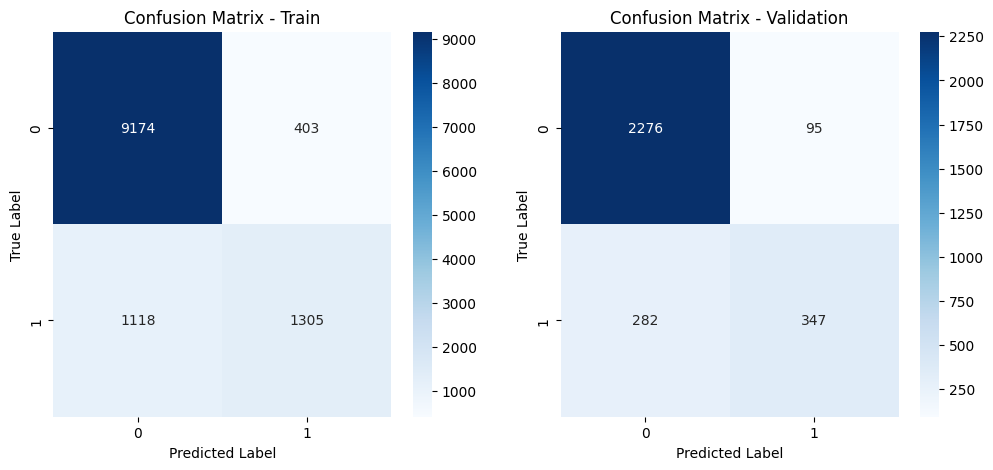

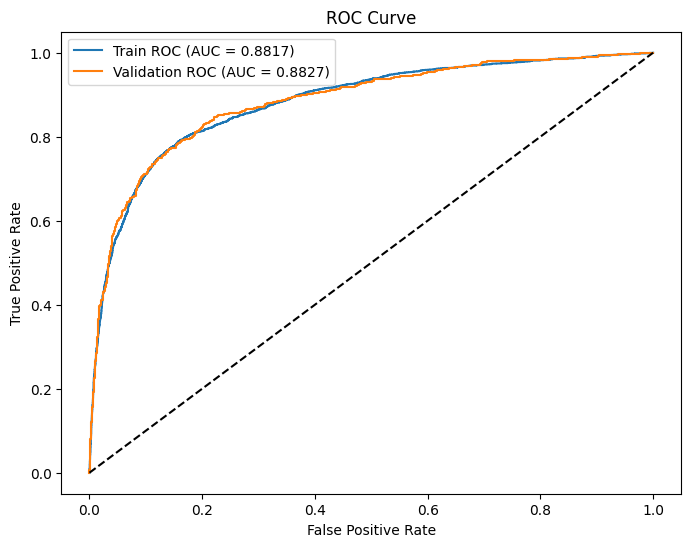

In [51]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

train_probs = model.predict_proba(X_train)[:, 1]
val_probs = model.predict_proba(X_val)[:, 1]

train_preds = (train_probs >= 0.5).astype(int)
val_preds = (val_probs >= 0.5).astype(int)

train_conf_matrix = confusion_matrix(train_targets, train_preds)
val_conf_matrix = confusion_matrix(val_targets, val_preds)

train_auc = roc_auc_score(train_targets, train_probs)
val_auc = roc_auc_score(val_targets, val_probs)

train_f1 = f1_score(train_targets, train_preds)
val_f1 = f1_score(val_targets, val_preds)

print(f"Train AUROC: {train_auc:.4f}, Train F1 Score: {train_f1:.4f}")
print(f"Validation AUROC: {val_auc:.4f}, Validation F1 Score: {val_f1:.4f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Confusion Matrix - Train")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Confusion Matrix - Validation")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.show()

train_fpr, train_tpr, _ = roc_curve(train_targets, train_probs)
val_fpr, val_tpr, _ = roc_curve(val_targets, val_probs)

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, label=f"Train ROC (AUC = {train_auc:.4f})")
plt.plot(val_fpr, val_tpr, label=f"Validation ROC (AUC = {val_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


**Висновки**

Модель має задовільну якість: хороші значення AUROC (~0.88) і збалансовані показники для тренувального та валідаційного наборів. Однак можна покращити точність, особливо для менш поширеного класу "1".

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [52]:
majority_class = train_targets.mode()[0]

majority_train_preds = [majority_class] * len(train_targets)
majority_val_preds = [majority_class] * len(val_targets)

majority_train_accuracy = sum(majority_train_preds == train_targets) / len(train_targets)
majority_val_accuracy = sum(majority_val_preds == val_targets) / len(val_targets)

train_accuracy = model.score(X_train, train_targets)
val_accuracy = model.score(X_val, val_targets)

print(f"Majority Class Accuracy (Train): {majority_train_accuracy:.4f}")
print(f"Majority Class Accuracy (Validation): {majority_val_accuracy:.4f}")
print(f"Trained Model Accuracy (Train): {train_accuracy:.4f}")
print(f"Trained Model Accuracy (Validation): {val_accuracy:.4f}")

print("Модель має хорошу якість, оскільки вона значно перевищує просту мажоритарну класифікацію.")


Majority Class Accuracy (Train): 0.7981
Majority Class Accuracy (Validation): 0.7903
Trained Model Accuracy (Train): 0.8732
Trained Model Accuracy (Validation): 0.8743
Модель має хорошу якість, оскільки вона значно перевищує просту мажоритарну класифікацію.


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [53]:
import joblib

save_path = "/mnt/data/log_reg.joblib"
joblib.dump({'model': model, 'scaler': scaler, 'imputer': imputer}, save_path)

loaded_objects = joblib.load(save_path)
model_2 = loaded_objects['model']

print(f"Завантажена модель: {model_2}")


Завантажена модель: LogisticRegression(max_iter=1000, random_state=42)


10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [54]:
# import warnings
# warnings.filterwarnings("ignore")

# def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
#     input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
#     input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
#     X_input = input_df[numeric_cols + encoded_cols]
#     prob = model.predict_proba(X_input)[:,1]
#     return prob

In [55]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, imputer, numeric_cols, categorical_cols, input_df: pd.DataFrame, model, train_cols):
    input_df = input_df.copy()

    input_df = pd.get_dummies(input_df, columns=categorical_cols, drop_first=True)

    missing_cols = set(train_cols) - set(input_df.columns)
    for col in missing_cols:
        input_df[col] = 0

    input_df = input_df[train_cols]

    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])

    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])

    prob = model.predict_proba(input_df)[:, 1]
    return prob


In [56]:
# predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [58]:
test_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/test.csv')

train_cols = list(X_train.columns)

test_df['Exited'] = predict_raw_df(
    scaler=scaler,
    imputer=imputer,
    numeric_cols=numeric_cols,
    categorical_cols = categorical_cols,
    input_df=test_df,
    model=model,
    train_cols = train_cols
)

test_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.034979
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.068731
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.298424
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.384576
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.119627


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [60]:
submission_df = pd.read_csv('bank-customer-churn-prediction-dlu-course-c-2/sample_submission.csv')

submission_df['Exited'] = predict_raw_df(
    scaler=scaler,
    imputer=imputer,
    numeric_cols=numeric_cols,
    categorical_cols=['Geography', 'Gender'],
    input_df=test_df,
    model=model,
    train_cols=train_cols
)

print(submission_df.head())

submission_df.to_csv("/mnt/data/submission_log_reg.csv", index=False)


      id    Exited
0  15000  0.068443
1  15001  0.030870
2  15002  0.155109
3  15003  0.197994
4  15004  0.050947
